# Project 4: Question Answering on Squad
## CS4740/5740 Fall 2020

### Project Submission Due: Monday, December 21, 11:59pm
Please submit a **pdf file** of this notebook on **Gradescope**, and **ipynb** on **CMS**. For instructions on generating pdf and ipynb files, please refer to the pinned Piazza post @695.



Name: Yichen Li

Netid: yl3475


This assignment is to be done **on your own**, i.e., without any teammate.

# Notes

---

1. Please read through the entire notebook before you start coding. That might inform your code structure.
2. Google colab does **not** provide good synchronization; we do not recommend multiple people to work on the same notebook at the same time.




# Overview

---

In this project you will develop NLP models for question-answering tasks. Specifically, you will train models on the SQuAD 2.0 dataset which contains questions on text segments from Wikipedia. The dataset aims to measure the reading comprehension capabilities of machines. Some examples from the main paper are given below. For Project 4, the task is divided into two parts. First, you will decide on a model by yourself and train it on this task. Secondly, you will fine-tune a pretrained model. 




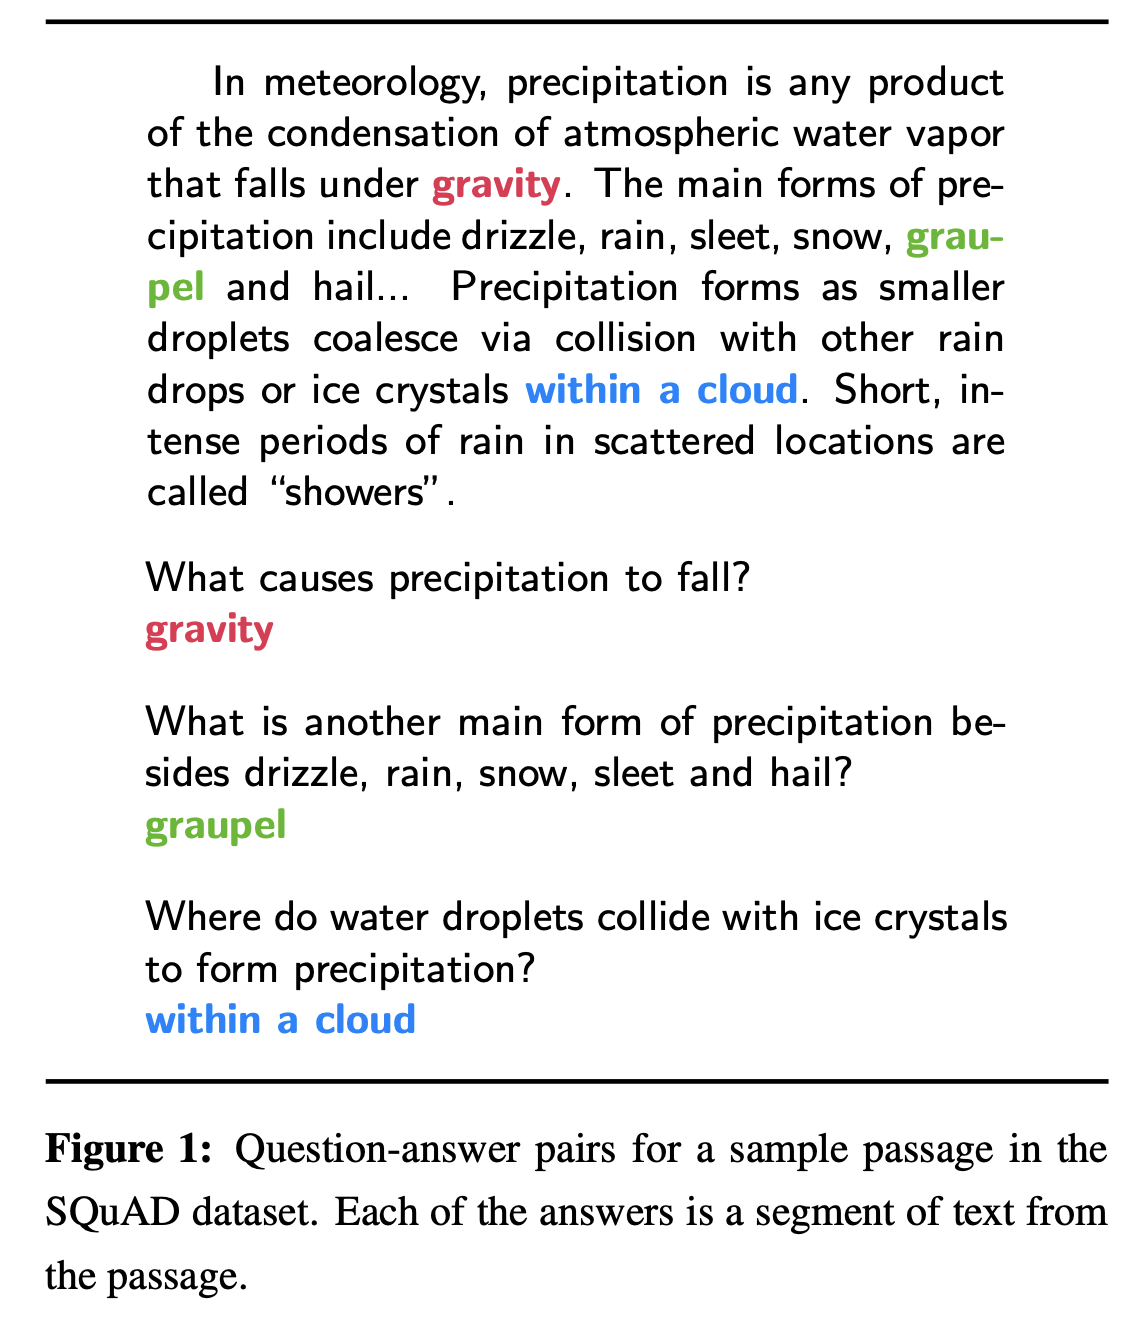

# Task and dataset

---

Obtain the data from [here](https://p4-squad-data.s3.us-east-2.amazonaws.com/train-v2.0.json). You also may consider doing so in a code block below.

```bash
!wget https://p4-squad-data.s3.us-east-2.amazonaws.com/train-v2.0.json
```

This gives you the dataset containing about 130,319 examples. You should split this into a **train** and **validation** dataset as in Project 2.


In [ ]:
import os
import collections
import json
import string
import re
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import pandas as pd
import nltk
nltk.download('punkt')
import numpy as np
import gc
import sklearn
from sklearn.model_selection import train_test_split
from torchtext import data
from torchtext.data import Field, Example
import torchtext.vocab as vocab
# import transformers

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
!wget https://p4-squad-data.s3.us-east-2.amazonaws.com/train-v2.0.json

--2020-12-21 20:19:15--  https://p4-squad-data.s3.us-east-2.amazonaws.com/train-v2.0.json
Resolving p4-squad-data.s3.us-east-2.amazonaws.com (p4-squad-data.s3.us-east-2.amazonaws.com)... 52.219.96.0
Connecting to p4-squad-data.s3.us-east-2.amazonaws.com (p4-squad-data.s3.us-east-2.amazonaws.com)|52.219.96.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘train-v2.0.json’

train-v2.0.json     100%[===================>]  40.17M  20.9MB/s    in 1.9s    

2020-12-21 20:19:18 (20.9 MB/s) - ‘train-v2.0.json’ saved [42123633/42123633]



### Q1: Initial data observations
What are your initial observations after you explore the dataset?

1. Max context length = 766
2. Min context length = 22
3. Average context length = 137.69
4. Max question length = 60
5. Min question length = 1
6. Average question length = 11.07
7. Min answer length = 1
8. Max answer length = 46
9. Average answer length = 2.58
10.  Median answer start index = 5


11. Total number of questions = 130319
12. Number of unanswerable questions = 43498


13. Number of contexts =  19029

The two metrics we will be using are **exact match** and **F1**. The exact match metric measures the percentage of predictions that match any one of the ground truth answers **exactly**. The F1 score is a looser metric, which measures the average overlap between the prediction and ground truth answer.

The F1 metric on answers is defined as:

$$F_1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$$

where $Precision$ is:
$$Precision = \frac{TP}{TP + FP} = \frac{\text{# of matching tokens}}{\text{# of predicted tokens}}$$

and $Recall$ is:
$$Recall = \frac{TP}{TP + FN} = \frac{\text{# of matching tokens}}{\text{# of gold tokens}}$$

and $TP$ refers to the number of true positives; $FP$ is the number of false positives; and $FN$ is the number of false negatives. (See Jurafsky & Martin Ch. 4.7).

These are then also averaged with the "has answer" prediction where we replace the individual question-answer pair score with a 1 if it correctly predicts that the question is not answerable, and keep the original score otherwise.

### Q1.1: The metrics

How much time does it take to compute these metrics? When will these metrics correlate well/poorly with human judgement of answer quality? Please implement the metric yourself.


#### Answer: 
Compute_EM run at O(1) for each a_gold, a_pred input pair. Since it is just comparing two input strings for exact match.

Compute_F1 runs at O(len(a)) where len(a) is the maximum length of the target and the answer string, because of the tokenization process before doing the common token matching. 

The Exact match I think generally works well, with some issues when the target answer only contains keyword, withoud "the", "a". However, if either one contains unimportant tokens like above, but get the basic idea right, human judgment will probabily determines such answers as correct, but EM will not. 
For this issue, the F1 score is better handling this issue when comparing target and prediction. Matching keywords will be found, and an overall score is returned based on the equation above. But it still will return a lower than human judgement score if "the" and "a" is present. 

In [ ]:
# Some potentially useful helper functions for the metrics
def remove_articles(text):
    regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
    return re.sub(regex, ' ', text)

def white_space_fix(text):
    return ' '.join(text.split())

def remove_punc(text):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in text if ch not in exclude)

def lower(text):
    return text.lower()

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    return white_space_fix(remove_articles(remove_punc(lower(s))))

def get_tokens(s):
    if not s:
        return []
    return normalize_answer(s).split()

In [ ]:
# Another batch of helper functions, feel free to modify as needed
def apply_no_ans_threshold(scores, na_probs, qid_to_has_ans):
    """apply_no_ans_threshold applies the no-answer threshold (or mapping) to
    the no-ans probabilities/predictions.

    :param scores: A mapping of qid to the f1 or em score
    :type scores: dict[qid: str, score: float]
    :param na_probs: A mapping of qid to the no answer prediction/probability
    :type na_probs: dict[qid: str, score: float]
    :qid_to_has_ans: A mapping of qid to answerability
    :type qid_to_has_ans: dict[qid: str, answerability: bool]
    :returns: A mapping of qid to new scores accounting for answerability
    :rtype: dict[qid: str, score: float]
    """
    new_scores = {}
    return new_scores

def make_eval_dict(exact_scores, f1_scores, qid_list=None):
    """make_eval_dict makes a dictionary from the individual scores of qa pairs.
    
    :param exact_scores: Mapping of qid to the em score
    :type exact_scores: dict[qid: str, score: float]
    :param f1_scores: Mapping of qid to f1 score
    :type f1_scores: dict[qid: str, score: float]
    :param qid_list: List of qid's to aggregate, used to separate HasAns and
        NoAns scores for better analysis of models
    :type qid_list: List[qid: str]
    :returns: mapping of relevant evaluation metrics to their scores
    :rtype: OrderedDict[value: str, score: float]
    """
    return collections.OrderedDict([
        ("exact", 0.),
        ("f1", 0.),
        ("total", 0.),
    ])

def merge_eval(main_eval, new_eval, prefix):
    """merge_eval is a helper to merge two outputs of make_eval_dict.

    This is useful for cases when we want to have the aggregate scores, but also
    want to look at the scores for HasAns and for NoAns. Using make_eval_dict,
    we can take only those that have an answer, compute and merge with the
    original eval_dict.

    :param main_eval: The main evaluation dictionary that you report from
    :type main_eval: dict[value: str, score: float]
    :param new_eval: The new evaluation dictionary that you want to merge in
    :type new_eval: dict[value: str, score: float]
    :param prefix: The prefix you want attached to the new_eval scores.
        For example, HasAns as a prefix can be used to get HasAns_f1.
    :type prefix: str
    :returns: combination of main_eval and new_eval with prefix on new_eval keys
    :rtype: OrderedDict[value: str, score: float]
    """
    for k in new_eval:
        main_eval['%s_%s' % (prefix, k)] = new_eval[k]

In [ ]:
# metric implementation here
def compute_exact(a_gold, a_pred):
    if len(a_gold) == 0 and len(a_pred) == 0:
        return 1
    
    elif len(a_pred) != 0 and len(a_gold) == 0:
        return 0
    
    else:
        if a_gold == a_pred:
            return 1
        else: 
            return 0


def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(gold_toks == pred_toks)
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

# Model 1: Pick your own model

---

In this part of the project you will implement a model to perform well on the SQuAD dataset. The features that you use are entirely up to you. As always, a good strategy is to work through lots of examples from the training data to determine what types of features would be most useful. You are **NOT** allowed to use (i) deep contextualized pre-trained language models (e.g. ELMo, GPT, BERT) since they will be covered in Part B, or (ii) any existing code written for the SQUAD task. Otherwise, feel free to re-use any code you have written for previous projects in the class as well as **general** ML/NLP tools (e.g., PyTorch, spaCy). Please use the code block below to code, prototype, and test your language model:

Code of Academic Integrity:  We encourage collaboration regarding ideas, etc. However, please **do not copy code from online or share code with other students**. We will be running programs to detect plagiarism.

## 1.1 Preprocessing
torchtext dataframe class, customized for reading pandas df

In [ ]:
class DataFrameDataset(Dataset):
    """Class for using pandas DataFrames as a datasource"""

    def __init__(self, examples, fields, filter_pred=None):
        """
        Create a dataset from a pandas dataframe of examples and Fields
        Arguments:
            examples pd.DataFrame: DataFrame of examples
            fields {str: Field}: The Fields to use in this tuple. The
                string is a field name, and the Field is the associated field.
            filter_pred (callable or None): use only exanples for which
                filter_pred(example) is true, or use all examples if None.
                Default is None
        """
        self.examples = examples.apply(SeriesExample.fromSeries, args=(fields,), axis=1).tolist()
        if filter_pred is not None:
            self.examples = filter(filter_pred, self.examples)
        self.fields = dict(fields)
        # Unpack field tuples
        for n, f in list(self.fields.items()):
            if isinstance(n, tuple):
                self.fields.update(zip(n, f))
                del self.fields[n]

class SeriesExample(Example):
    """Class to convert a pandas Series to an Example"""

    @classmethod
    def fromSeries(cls, data, fields):
        return cls.fromdict(data.to_dict(), fields)

    @classmethod
    def fromdict(cls, data, fields):
        ex = cls()

        for key, field in fields.items():
            if key not in data:
                raise ValueError("Specified key {} was not found in "
                                  "the input data".format(key))
            if field is not None:
                setattr(ex, key, field.preprocess(data[key]))
            else:
                setattr(ex, key, data[key])
        return ex

In [ ]:
def get_char_word_loc_mapping(context, context_tokens):
    """
    Return a mapping that maps from character locations to the corresponding token locations.
    If we're unable to complete the mapping e.g. because of special characters, we return None.
    Inputs:
      context: string (unicode)
      context_tokens: list of strings (unicode)
    Returns:
      mapping: dictionary from ints (character locations) to (token, token_idx) pairs
        Only ints corresponding to non-space character locations are in the keys
        e.g. if context = "hello world" and context_tokens = ["hello", "world"] then
        0,1,2,3,4 are mapped to ("hello", 0) and 6,7,8,9,10 are mapped to ("world", 1)
    """
    acc = '' # accumulator
    current_token_idx = 0 # current word loc
    mapping = dict()

    for char_idx, char in enumerate(context): # step through original characters
        if char != u' ' and char != u'\n': # if it's not a space:
            acc += char # add to accumulator
            context_token = str(context_tokens[current_token_idx]) # current word token
            if acc == context_token: # if the accumulator now matches the current word token
                syn_start = char_idx - len(acc) + 1 # char loc of the start of this word
                for char_loc in range(syn_start, char_idx+1):
                    mapping[char_loc] = (acc, current_token_idx) # add to mapping
                acc = '' # reset accumulator
                current_token_idx += 1

    # if current_token_idx != len(context_tokens):
    #     return None

    return mapping

In [ ]:
filename = 'train-v2.0.json'
with open(filename, 'r') as f:
    dataset = json.load(f)

record_path = ['data', 'paragraphs', 'qas', 'answers']
js = pd.json_normalize(dataset, record_path)
m = pd.json_normalize(dataset, record_path[:-1])
r = pd.json_normalize(dataset,record_path[:-2])
idx = np.repeat(r['context'].values, r.qas.str.len())
ndx  = np.repeat(m['id'].values, m['answers'].str.len())
m['context'] = idx
js['q_idx'] = ndx
main = pd.concat([m[['id', 'question', 'context', 'is_impossible']].set_index('id'), js.set_index('q_idx')], 1, sort=False).reset_index()
main['c_id'] = main['context'].factorize()[0]

In [ ]:
del dataset
gc.collect()

19070

In [ ]:
QUESTION = data.Field(include_lengths=True, tokenize='spacy')
TEXT = data.Field(include_lengths=True, tokenize='spacy')
LABEL = data.Field(pad_token=None)

# fields = {'question': ('q', QUESTION), 'context':  ('t', TEXT), 'text': ('l', LABEL)}
fields = {'question': QUESTION, 'context': TEXT, 'text': LABEL}

train, test = train_test_split(main, test_size=0.2, random_state=1)

data = DataFrameDataset(train, fields)

MAX_VOCAB_SIZE = 25000
embedding_300d = os.path.join(os.getcwd(), 'glove.6B.300d.txt')
custom_emb = vocab.Vectors(name=embedding_300d)
TEXT.build_vocab(train, max_size=MAX_VOCAB_SIZE, vectors=custom_emb, unk_init=torch.Tensor.normal_)

In [ ]:
def map_to_vector(context_tokens, word_dict, flag):
    vector_lst = []
    question_fill = 60
    context_fill = 766
    curr_count = 0
    for each in context_tokens:
        vector_lst.append(word_dict[each])
        curr_count += 1

    if flag == 'c':
        vector_lst.extend([1] * (context_fill - len(vector_lst)))
    if flag == 'q':
        vector_lst.extend([1] * (question_fill - len(vector_lst)))

    return vector_lst

In [ ]:
def get_start_index(mapping, start_position):
    start_index = 0
    try:
        start_index = mapping[start_position][1]
    except:
        start_index = 0

    return start_index

In [ ]:
main['tokenized_question'] = main.apply(lambda row: nltk.word_tokenize(row['question']), axis=1)
main['question_length'] = main.apply(lambda row: len(row['tokenized_question']), axis=1)

In [ ]:
main['tokenized_context'] = main.apply(lambda row: nltk.word_tokenize(row['context']), axis=1)
main['context_length'] = main.apply(lambda row: len(row['tokenized_context']), axis=1)

In [ ]:
main['tokenized_text'] = main.apply(lambda row: nltk.word_tokenize(str(row['text'])), axis=1)
main['text_length'] = main.apply(lambda row: len(row['tokenized_text']), axis=1)

In [ ]:
context_series = main['tokenized_context']
context_vector = context_series.map(lambda x: map_to_vector(x, word_dict, flag='c'))
main['context_vector'] = context_vector

question_series = main['tokenized_question']
question = question_series.map(lambda x: map_to_vector(x, word_dict, flag='q'))
main['question_vector'] = question

In [ ]:
main['context_mapping'] = main.apply(lambda row: get_char_word_loc_mapping(row['context'], row['tokenized_context']), axis=1)
main['start_index'] = main.apply(lambda row: get_start_index(row['context_mapping'], row['answer_start']), axis=1)

In [ ]:
main['context_mapping'] = ""

In [ ]:
# token_start_0 = main.loc[main['start_index']==0]
# start_0_answerable_index = token_start_0[token_start_0['is_impossible']==False].index
# main = main.drop(start_0_answerable_index, inplace=True)

In [ ]:
start_index_list = main['start_index'].to_list()
text_length_list = main['text_length'].to_list()
end_index_list = [a+b for a, b in zip(start_index_list, text_length_list)]
main['end_index'] = end_index_list

In [ ]:
# download df to local
import pickle
main.to_pickle("main_df")

In [ ]:
df = main

#### LOAD pickled dataframe from Drive

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
get_device = lambda : "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
# load df
df_path = os.path.join(os.getcwd(), "drive", "My Drive", "Colab Notebooks", "df.pkl")
df = pd.read_pickle(df_path)

In [ ]:
emb_path = os.path.join(os.getcwd(), "drive", "My Drive", "Colab Notebooks", "embedding.npy")
with open(emb_path, 'rb') as f:
     emb = np.load(f)


In [ ]:
class SentenceAlignAttention(nn.Module):
    def __init__(self, input_size):
        super(SentenceAlignAttention, self).__init__()

        self.linear_transformation = nn.Linear(input_size, input_size)
        self.relu = nn.ReLU(inplace=True)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, question_emb_vector, context_emb_vector):
        trans_question = self.linear_transformation(question_emb_vector)
        trans_context = self.linear_transformation(context_emb_vector)
        question_projection = self.relu(trans_question)
        context_projection = self.relu(trans_context)
        
        question_projection = torch.squeeze(question_projection, 1)
        context_projection = torch.squeeze(context_projection, 1)
        # print(f'question dimension is : {question_projection.size()}')
        # print(f'context dimension is : {context_projection.size()}')
        

        score = torch.mm(context_projection, torch.transpose(question_projection,0,1))

        score = score.masked_fill(score==0, -np.inf)
        # print(f'score before softmax: {score.size()}')
        # print(score)
        score = self.softmax(score)

        # print(f'shape of score matrix: {score.size()}')
        # print(f'shape of quesition emb vector: {question_emb_vector.size()}')
        #766 x 60 
        #60 x 1 x 300
        #1 x 766 x 300
        context_score = torch.matmul(score, torch.squeeze(question_emb_vector, 1))
        context_score = torch.unsqueeze(context_score, 0)
        # print(f'shape of context score is : {context_score.size()}')
        return context_score

        


In [ ]:
class DRQAModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers, dropout, pad_idx, batch_size):
        super(DRQAModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.pLSTM = nn.LSTM(embed_dim, hidden_dim, num_layers=n_layers, dropout=dropout, bidirectional=True)
        self.qLSTM = nn.LSTM(embed_dim, hidden_dim, num_layers=n_layers, dropout=dropout, bidirectional=True)
        
        # self.self_attention = nn.Linear(hidden_dim, output_dim)
        self.aggregate_layer = nn.Conv1d(in_channels=60, out_channels=1, kernel_size=1)
        # self.self_attention = SelfAttention(input_size=hidden_dim*2, output_size=1)
        self.question_trans = nn.Linear(hidden_dim*2, hidden_dim*2)
        self.sentence_align_attention = SentenceAlignAttention(embed_dim)
        self.start_output = nn.Linear(hidden_dim*2, 1)
        self.end_output = nn.Linear(hidden_dim*2, 1)
        self.softmax = nn.LogSoftmax(dim=1)
        self.loss = nn.CrossEntropyLoss()

    def compute_loss(self, start_vector, end_vector, gold_start, gold_end):
        return self.loss(start_vector, gold_start) + self.loss(end_vector, gold_end)

    def forward(self, question_input, question_length, context_input, context_length):
        embedded_question = self.embedding(question_input)
        embedded_context = self.embedding(context_input)
        # print(f'question embed dim: {embedded_question.size()}')
        question_out, _ = self.qLSTM(embedded_question)
        # print(f'question_lstm_output dim: {question_out.size()}')
        # question_self_weights = self.self_attention(question_out)
        # quesiton_weights = nn.Softmax(transformed_question)
        # print(f'self_weight dim: {question_self_weights.size()}')
        question_score = self.aggregate_layer(question_out.permute(1, 0, 2))
        # question_score = question_out * question_self_weights
        # print(f'question score shape: {question_score.size()}')

        context_representation = self.sentence_align_attention(embedded_question, embedded_context)

        # print(f'context embed dim: {embedded_context.size()}')
        context_out, _ = self.pLSTM(context_representation)
        
        # transformed_question = self.question_trans(question_score)
        # print(transformed_question)
        
        # context_out = torch.squeeze(context_out, 0)
        # print(f'context representation shape: {context_out.size()}')
        # transformed_question = torch.squeeze(transformed_question,1)
        # print(f'trans ques shape: {transformed_question.size()}')
        # print(f'transposed question: {torch.transpose(transformed_question, 0, 1).size()}')
        # mult_context = torch.matmul(transformed_question, context_out)
        # print(f'shape of mult_context: {mult_context.size()}')

        start_vec = self.start_output(context_out)
        # print(f'shape of start_vec {start_vec.size()}')
        end_vec = self.end_output(context_out)

        # start_pred = self.softmax(start_vec)
        # end_pred = self.softmax(end_vec)

        return start_vec, end_vec



In [ ]:
def row_to_train_data(row):
    question_length = row['question_length']
    question_tensor = torch.LongTensor(row['question_vector'])
    context_length = row['context_length']
    context_tensor = torch.LongTensor(row['context_vector'])
    gold_start = row['start_index']
    gold_end = row['end_index']
    return context_tensor, context_length, question_tensor, question_length, gold_start, gold_end

In [ ]:
vocab_size = 25002
embedding_dim = 300
hidden_dim = 512

n_layers = 2
pad_idx = 1
batch_size = 1
lr = 0.0001

drqa = DRQAModel(vocab_size=vocab_size, embed_dim=embedding_dim, hidden_dim=hidden_dim, output_dim=embedding_dim, n_layers=n_layers, dropout=0, pad_idx=pad_idx, batch_size=batch_size).to(get_device())
optimizer = torch.optim.Adam(drqa.parameters(), lr=lr)
drqa.embedding.weight.data.copy_(torch.from_numpy(emb))

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0466,  0.2132, -0.0074,  ...,  0.0091, -0.2099,  0.0539],
        ...,
        [ 0.1905,  0.0919,  0.2124,  ..., -0.3644,  0.1108, -0.2712],
        [ 0.1651,  0.2294,  0.0933,  ...,  0.1963,  0.2784,  0.3328],
        [ 0.6227, -0.2053,  0.3589,  ...,  0.1131, -0.0468, -0.3559]],
       device='cuda:0')

In [ ]:
def train(df, model, optimizer):
    
    model.train()
    counter = 0
    epoch_loss = 0
    for index, row in df.iterrows():
        optimizer.zero_grad()
        context_tensor, context_length, question_tensor, question_length, gold_start, gold_end = row_to_train_data(row)
        # print(torch.unsqueeze(context_tensor, -1).size())
        
        start_pred, end_pred = model(torch.unsqueeze(question_tensor, -1).to(get_device()), torch.LongTensor([question_length]), torch.unsqueeze(context_tensor, -1).to(get_device()), torch.LongTensor([context_length]))
        # gold_start = torch.tensor([gold_start] ,dtype=torch.long)
        # gold_end = torch.tensor([gold_end] ,dtype=torch.long)
        # print(torch.LongTensor([[gold_start]]).size())
        loss = model.compute_loss(start_pred, end_pred, torch.LongTensor([[gold_start]]).to(get_device()), torch.LongTensor([[gold_end]]).to(get_device()))
        # print('****************************')
        # print('model parameter')
        # for name, param in model.named_parameters():
        #   if param.requires_grad:
        #       print(name, param.data)
        loss.backward()
        optimizer.step()
        # print('++++++++=======+++++++++++=====')
        # print('After STEP PARAM')
        # for name, param in model.named_parameters():
        #   if param.requires_grad:
        #       print(name, param.data)
        epoch_loss += loss.item()
        # print(type(loss.item()))
        # print(loss.item())
        if np.isnan(loss.item()):
            print(f'index in the dataframe: {index}')
            print(f'context_len is: {context_length}')
            print(f'question_len is: {question_length}')
            print(f'start index is: {gold_start}')
            print(f'end index is: {gold_end}')
            print('++++++++=======+++++++++++=====')
            for name, param in model.named_parameters():
                if param.requires_grad:
                    print(name, param.data)
            break
        counter += 1
      
    return epoch_loss/counter

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [ ]:
epoch = 5

for i in range(epoch):
  
  print(f'Epoch: {i}')
  train_loss = train(df_train, drqa, optimizer)
  print(f'Train Loss {train_loss:.3f}')
  checkpt_name = 'drqa_{}.p'.format(i)
  state = {'net': drqa.state_dict(), 'optimizer': optimizer.state_dict(),}
  torch.save(state, checkpt_name)


Epoch: 0
Train Loss 9.290
Epoch: 1
Train Loss 8.848
Epoch: 2
Train Loss 8.745
Epoch: 3
Train Loss 8.665
Epoch: 4
Train Loss 8.576


In [ ]:
checkpt_name = 'drqa.p'
state = {'net': drqa.state_dict(), 'optimizer': optimizer.state_dict(),}
torch.save(state, checkpt_name)

In [ ]:
for name, param in drqa.named_parameters():
    if param.requires_grad:
        print(name, param.data)



### Q2 : Explain your  implementation

Q2.1: Explain here your implementation (e.g. **which algorithms/data structures** you used). Make clear which parts were implemented from scratch vs. obtained via an existing package. 

**Answer:** For the first model, I was following the description of @1161 on Piazza posted by Magd, to build a DrQA document reader.

#### Document preprocessing: 

For the preprocessing part, I first used pandas to read the JSON file and extracting fields from the structured JSON file using the json_normalize function. Then I concatenated columns from the extracted fields to form a complete dataframe that includes the following columns: index, id, question, context, is_impossible, text, and answer_start.

For building the vocabulary and word to index part, I used torchtext field from the last project. In order to use torchtext field.build_vocab(), I need to put my dataframe into a torchtext DataframeDataset. I found a modified version of that class so that the class can instanitiate a DataframeDataset class from pandas dataframe. With a torchtext dataset object, I can build vocabulary for the context. 

The vocabulary maps word token to index, I used vocabulary dictionary to map tokenized context and tokenized question to index vectors. With embedding layer, I can construct embedding representations on the fly withoud needing to store all the embedding vectors forefront.

Since we need to find the answer span in the context, the char index of the answer start position is not going to very helpful. So I called function to creat a mapping for each char corresponding to the index of each token. This step is been taken care of by the BertWordPieceTokenizer in model2 preprocessing. With the char index to token index mapping, I will put in the new token start and end index accordingly into the dataframe. 

#### Document reading Model
We are pretty much done with data preprocessing at this point and we can construct our model. The model is structure of the model is following the drqa paper, with two stacked Bi-directional LSTM to preocess question and context separately. In order to put attention on context that can related to different questions, aligned question embedding is used. And the attentive context embedding is passed into a stacked Bi-LSTM to get the hidden representation of the context.

Self Attnetion is applied to the question hidden representation output by the Bi-LSTM for question embeddings. I applied linear transformation on the output and do a weighted average on the linear transformed on the output using a Cov1d layer to do that. And Finally, two linear layer is going to output one value for each token position in the context. And CrossEntropyLoss is used to compute loss by calculate the difference between the gold target index with the predicted span index. 

Q2.2: Explain and motivate any design choices providing the intuition behind them (e.g. which methods you used for your implementation, why?).

**Answer:**  So for the design decision for this model, I want to stick with a neural network solution just to see how am I capable of actually constructing a more complex neural net compared to the RNN model from Project 3. Although a logistic regression model might work just as fine, I think a model utilizes attention mechanism and Bi-LSTM can actually outperform the feature based Logistic Regression model. Since LSTMs are capable of reading the context both ways, it can capture some underlying features that human engineered features aren't going to discover or too complex to engineer forefront. 

Also the aligned attention embedding from the DrQA paper is important because, it is going to work like exact question word matching or POS tagging or coreference tagging when the linear layer used to construct it learns its weight during training. The outcome of the aligned attention embedding is critical in identifying the correct part of the context to look at when picking the correct answer span.

The self attention mechanism is chose to also learn a weight on different quesiton tokens as we train the model. I imagine it works when there's a lot of questions start with "what", "when", "who" combined with other component in the system, it could pick out the differences and shift the attention on particular part of the input.


Q2.3: What features did you use and why? Please motivate your choices.

**Answer:** For both the question and context representation. I chose to use GloVe embedding with 300 dimension for each word token, and since we are doing question answering with Wikipedia articles as our context, I used GloVe embedding that are trained with Wikipedia corpus. 

For other features like adding exact match and POS tags onto the context vectors, I do not see a feasible way to do that in the preprocessing stage. Furthermore, since my inputs into the model are vocab indexes and they will be converted into embedding vectors in the embedding layer in the forward(), I am not sure how to process the addtional feature vector after that. So I did not use additinal features apart from GloVe embeddings.



## Validation Step



In [ ]:
def row_to_val_data(row):
    question_length = row['question_length']
    question_tensor = torch.LongTensor(row['question_vector'])
    context_length = row['context_length']
    context_tensor = torch.LongTensor(row['context_vector'])
    # text = row['text']
    gold_start = row['start_index']
    gold_end = row['end_index']
    return context_tensor, context_length, question_tensor, question_length, gold_start, gold_end

In [ ]:
def compute_em(gold_start, gold_end, answer_start, answer_end):
    if gold_start == answer_start:
        if gold_end == answer_end:
            return 1
        else:
            return 0
    else:
        return 0

In [ ]:
def compute_overlap(gold_start, gold_end, answer_start, answer_end):
    return max(0, min(gold_end, answer_end) - max(gold_start, answer_start) + 1);

In [ ]:
# Evaluate/validate your model here
# you may attach pictures of graphs etc.
def validate(dataframe, model):
    model.eval()
    counter = 0
    correct = 0
    answer_span_length = 0
    num_of_overlap = 0
    for index, row in df.iterrows():
        # print(" i am in here")
        context_tensor, context_length, question_tensor, question_length, gold_start, gold_end = row_to_val_data(row)
        # print(torch.unsqueeze(context_tensor, -1).size())
        
        start_pred, end_pred = model(torch.unsqueeze(question_tensor, -1).to(get_device()), torch.LongTensor([question_length]), torch.unsqueeze(context_tensor, -1).to(get_device()), torch.LongTensor([context_length]))
        softmax_start = F.softmax(start_pred, dim=1)
        softmax_end = F.softmax(end_pred, dim=1)

        answer_start = torch.argmax(softmax_start)
        answer_end = torch.argmax(softmax_end)

        correct += compute_em(gold_start, gold_end, answer_start, answer_end)
        num_of_overlap += compute_overlap(gold_start, gold_end, answer_start, answer_end)
        # print(f'gold start is : {gold_start} ### my start is : {answer_start}')
        # print(f'gold end is : {gold_end}   ### my end is : {answer_end}')
        answer_span_length += (gold_end - gold_start + 1)
        print(counter)
        counter += 1

        
    return correct/counter, num_of_overlap/answer_span_length

In [ ]:
model_path = os.path.join(os.getcwd(), "drive", "My Drive", "Colab Notebooks", "drqa_4.p")
drqa.load_state_dict(torch.load(model_path)['net'])

<All keys matched successfully>

In [ ]:
validate(df_test, drqa)

### Q3: Results Analysis

Q3.1: Explain here how you evaluated the models. Summarize the performance of your system and any variations that you experimented with on the validation datasets. Put the results into clearly labeled tables or diagrams and include your observations and analysis. 

**Answer:**  For the performance evaluation part. I used an model image that is trained with 5 epoches. 

I ran the test_df which is 20% of the squad_train_v2.0 dataset. I computed the percentage of EM with matching start and end index between gold target and predited output. About 2% of the predictions were exactly matching. 

Another metric I implemented for this model is to compute the partial match using gold target and predicted outputs. The equation of the metrics is by counter how many overlapping indexes between the target span and the predicted span. For example, [2, 5] and [3, 4] will have 2 overlap integer numbers, thus the predicted output has two word tokens exactly matches the gold target. Then the number of overlapped indexes is divided by the number of indexes in the target span.

In the end, 18.3% of the predicted span matches the target span according to the metrics calculated above.


Q3.2: When did the system work well? When did it fail?  Any ideas as to why? How might you improve the system?

**Answer:** Based on the evaluation on the test test, I was not able to tell on what types of questions or context will the model make more accurate predictions and when will the model performs badly on the questions. Part of the reason the predictions were leaning towards a particular type of data might come from the not enough training done on the model with only 5 epoches. The model is yet to learn question specific structure or connection between questiona and context. And maybe another reason for not able to tell a difference is that in general the model did not have a answer type feature that are capable of capturing which part of context is going to be highly related to an asnwer type. 

Q3.3: What is the effect of the method used for handling unknown words? Note: Even if you choose to skip over unknown words, that is still a _method_ of handling out-of-vocabulary terms.

**Answer:** The out of vocabulary words in validation set and test set are replaced by <unk> tokens and subsequently indexed to reflect that property, and the embedding for <unk> tokens are all 0s. Since we are picking answe spans from context paragraphs. We are not going to encounter the situation when the context is seen, and there's an unkown word in the answer. And often time, critical question tokens are common words or appears in context first. So the time we need to deal with the out of vocabulary word is when we are reading an unseen passage or unseen word in question. Since we rarely pick <unk> as our answer span in training, during testing, when the answer span contains out of vocabulary words. A performance decrease is going to be observed, because the training set will probabily correlate <unk> with low possibility of being the answer and thus during testing, the model will pick some other span.



# Part B: Fine-tune a Pre-trained Language Model

---

In this part, the goal is to build a strong system by fine-tuning a pre-trained language model. You can use **any** public code, **any** pre-trained language models, and **any** hardware resources -- anything other than code specifically written for SQUAD. A reasonable baseline F1 score to aim for is around 0.7.



In [ ]:
!pip install transformers

     |████████████████████████████████| 1.5MB 13.4MB/s 
     |████████████████████████████████| 2.9MB 39.9MB/s 
     |████████████████████████████████| 890kB 52.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=6ed56892ec024994a2724162243956173ab059f9a39575aee6b1d0eb082f9ed1
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer

In [ ]:
df_path = os.path.join(os.getcwd(), "drive", "My Drive", "Colab Notebooks", "main_df")
main = pd.read_pickle(df_path)

In [ ]:
main = main[["question", "context", "text", "answer_start"]]
answer_start = main['answer_start'].to_list()
answer_start = [x if not np.isnan(x) else -1 for x in answer_start]
main['answer_start'] = answer_start
main['text_len'] = main.apply(lambda row: len(str(row['text'])) if not np.isnan(row['answer_start']) else 0, axis=1)
main['answer_end'] = main.apply(lambda row: row['answer_start']+row['text_len'], axis=1)

In [ ]:
from tokenizers import BertWordPieceTokenizer
vocab_path = os.path.join(os.getcwd(), "drive", "My Drive", "Colab Notebooks", "bert-base-uncased-vocab.txt")
tokenizer2 = BertWordPieceTokenizer(vocab_path, lowercase=True)

In [ ]:
start_token_idx = []
end_token_idx = []

for index, row in main.iterrows():
    if row['answer_start'] == -1 or row['answer_end'] == -1:
        start_token_idx.append(0)
        end_token_idx.append(0)
        continue

    context_tokens = tokenizer2.encode(row['context'])

    char_is_ans = [0]*len(str(row['context']))
    for idx in range(int(row['answer_start']), int(row['answer_end'])):
        char_is_ans[idx] = 1

    ans_token_index = []

    for idx, (start, end) in enumerate(context_tokens.offsets):
        if sum(char_is_ans[start:end]) > 0:
            ans_token_index.append(idx)

    start_token_idx.append(ans_token_index[0])
    end_token_idx.append(ans_token_index[-1])

main['start_index'] = start_token_idx
main['end_index'] = end_token_idx

In [ ]:
main.drop(main[main['start_index'] > 500].index, inplace = True)

In [ ]:
class SquadDataset(Dataset):
    def __init__(self, question, context, text, start_index, end_index, tokenizer, max_len):
        self.question = question
        self.context = context
        self.text = text
        self.start_index = start_index
        self.end_index = end_index
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.question)

    def __getitem__(self, item):
        question = str(self.question[item])
        context = str(self.context[item])
        text = str(self.text[item])
        start_index = self.start_index[item]
        end_index = self.end_index[item]

        encoding = tokenizer.encode_plus(
            question,
            context,
            max_length=self.max_len,
            add_special_tokens=True,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'question' : question,
            'context' : context,
            'text' : text,
            'input_ids' : encoding['input_ids'].flatten(),
            'attention_mask' : encoding['attention_mask'].flatten(),
            'token_type_ids' : encoding['token_type_ids'].flatten(),
            'start_index' : start_index,
            'end_index' : end_index,
        }

def create_data_loader(df, tokenizer, max_len, batch_size):
    dataset = SquadDataset(
        question = main.question.to_numpy(),
        context = main.context.to_numpy(),
        text = main.text.to_numpy(),
        start_index = main.start_index.to_numpy(),
        end_index = main.end_index.to_numpy(),
        tokenizer = tokenizer,
        max_len= max_len,
    )

    return DataLoader(dataset, batch_size=batch_size)

In [ ]:
df_train, df_test = train_test_split(main, test_size=0.2, random_state=1)

In [ ]:
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=1)

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
MAX_LEN = 512
BATCH_SIZE = 16
train_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)


In [ ]:
val_loader = create_data_loader(df_val, tokenizer, MAX_LEN, batch_size=1)

In [ ]:
test_loader = create_data_loader(df_test, tokenizer, MAX_LEN, batch_size=1)

In [ ]:
class SquadWithBert(nn.Module):
    def __init__(self):
        super(SquadWithBert, self).__init__()

        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.l1 = nn.Linear(self.bert.config.hidden_size, 1)
        self.l2 = nn.Linear(self.bert.config.hidden_size, 1)
        # self.softmax = nn.LogSoftmax(dim=1)
        self.loss = nn.CrossEntropyLoss(ignore_index=512)

    def compute_loss(self, start_pred, end_pred, start_gold, end_gold):
        return self.loss(start_pred, start_gold) + self.loss(end_pred, end_gold)

    def forward(self, input_ids, attention_mask, type_ids):
        outputs = self.bert(input_ids, attention_mask, type_ids)
        last_hidden_state = outputs.last_hidden_state
        start_output = self.l1(last_hidden_state)
        end_output = self.l2(last_hidden_state)
        # start_vec = self.softmax(start_output)
        # end_vec = self.softmax(end_output)

        return start_output, end_output

In [ ]:
def train(dataloader, model, optimizer, batch_size):
    model.train()
    epoch_loss = 0

    for item in dataloader:
        optimizer.zero_grad()
        input_ids = item['input_ids'].to(get_device())
        attention_mask = item['attention_mask'].to(get_device())
        token_type_ids = item['token_type_ids'].to(get_device())
        start_index = item['start_index'].to(get_device())
        end_index = item['end_index'].to(get_device())
        
        if len(start_index) < 4:
          continue

        start_output, end_output = model(input_ids, attention_mask, token_type_ids)
        # print(start_output)
        # start_prediction = torch.argmax(start_output, dim=1)[:, :1]
        # end_prediction = torch.argmax(end_output, dim=1)[:, :1]
        # print(start_prediction)
        # num_of_correct_prediction = get_accuracy(start_prediction, end_prediction, start_index, end_index)
        loss = model.compute_loss(start_output, end_output, torch.unsqueeze(start_index, dim=-1), torch.unsqueeze(end_index, dim=-1))
        # print(start_index, end_index)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        # break
    return epoch_loss

In [ ]:
bert_squad = SquadWithBert().to(get_device())
optimizer = torch.optim.AdamW(bert_squad.parameters(), lr=3e-5)

In [ ]:
next(bert_squad.parameters()).device

device(type='cuda', index=0)

In [ ]:
epoch = 5

for i in range(epoch):
  
  print(f'Epoch: {i}')
  train_loss = train(train_loader, bert_squad, optimizer, BATCH_SIZE)
  print(f'Train Loss {train_loss:.3f}')
  checkpt_name = 'bert_{}.p'.format(i)
  state = {'net': bert_squad.state_dict(), 'optimizer': optimizer.state_dict(),}
  torch.save(state, checkpt_name)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Epoch: 0


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train Loss 43026.693
Epoch: 1
Train Loss 29087.472
Epoch: 2
Train Loss 22245.871
Epoch: 3
Train Loss 17640.037
Epoch: 4
Train Loss 14368.445


In [ ]:
model_path = os.path.join(os.getcwd(), "drive", "My Drive", "Colab Notebooks", "bert_2.p")
bert_squad.load_state_dict(torch.load(model_path)['net'])

<All keys matched successfully>

In [ ]:
def validate(model, dataloader, tokenizer):
    model.eval()
    f1_score = 0
    counter = 0
    for item in dataloader:
        input_ids = item['input_ids'].to(get_device())
        attention_mask = item['attention_mask'].to(get_device())
        token_type_ids = item['token_type_ids'].to(get_device())
        answer_gold = item['text']

        start_output, end_output = model(input_ids, attention_mask, token_type_ids)
        softmax_start = F.softmax(start_output, dim=1)
        softmax_end = F.softmax(end_output, dim=1)

        answer_start = torch.argmax(softmax_start)
        answer_end = torch.argmax(softmax_end)

        tokens = tokenizer.convert_ids_to_tokens(torch.squeeze(input_ids, 0))
        # print(tokens)
        answer = tokens[answer_start]

        for i in range(answer_start + 1, answer_end + 1):
            
            # If it's a subword token, then recombine it with the previous token.
            if tokens[i][0:2] == '##':
                answer += tokens[i][2:]
            
            # Otherwise, add a space then the token.
            else:
                answer += ' ' + tokens[i]
        # print(f'gold is : {str(answer_gold)}')
        # print(f'my answer is : {answer}')
        f1_score += compute_f1(str(answer_gold), answer)
        
        if counter > 100:
            return f1_score/counter
        
        counter += 1
        # print(f'F1 score is: {f1_score}')
        # break

In [ ]:
validate(bert_squad, test_loader, tokenizer)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


0.01504007543611504

### Q4: Implementation Details

Q4.1: Explain here how you implemented the fine-tuning (e.g. which algorithms/data structures you used, what features are included). Make clear which parts were implemented from scratch vs. obtained via an existing package. 


**Answer:**  This part is about fine-tuning a Huggingface BertModel.
#### Preprocessing:
The preprocessing part differs from the precious model in the following way:
I used BertTokenizer to tokenized context and question sentences. The ecnode_plus() method took care of converting word tokens into the vocabulary dictionary index, padding the vectors to MAX_LEN of 512, and also returns attention mask, and token_type_ids. It is really convienient to then feed the dataframe to a Dataset and use dataloader to generate designated batch_size for training.

#### Model build:
 The model itself does not require to mannually covert embedding using nn.Embedding. The input consists of three tensors: input_ids, attention_mask, and token_type_ids. The output of the BertModel I used is the last hidden representation, with size batch_size X 512 x 768. Then I passed the output to two separate linear layer which weights can be learned individually to convert the output to the size of batch_size X 512 X 1. Then I used CrossEntropyLoss to compute the loss between the target and the prediction. 
 For selecting the answer span, I chose to use the naive algorithm the same as model1. And the answerablility is handled by the output index. The unasnwerable indexes are 0, whereas the asnwerable indexes start from 1. 




### Q5: Results Analysis

Q5.1: Explain here how you evaluated the model. Summarize the performance of your system and any variations that you experimented with the validation datasets. Put the results into clearly labeled tables or diagrams and include your observations and analysis. 

**Answer:** 
The model image that I managed to save and download to disk is trained with 3 epochs. However the training is managed to finish 5 epochs with decreasing loss observed after 3 epochs. Then Safari crashed.

For the evaluation part. I ran the model through validation dataset entry by entry with a batch size just 1. And I print out my predicted answer span and my gold answer text. Printing out the answer and target text make it easier to see the actually performance of the model. Besides printing out the output from the model and compare with my eyes, I computed F1 score for each output, gold pair for reference and metric. Often time, my model outputs completely different answer spans than the gold target text, and therfore has a F1 score of 0. 

I suspect that the low performance of my model is caused by the naive span picking algorithm. For the model, I have two outputs, one vector for start index and one for end index. Current implementation uses argmax on each vector to pick the index with largest softmax scores. And the predicted answer span is formed by picking out the start to end index in the context paragraph. This naive approach compared to algorithms like finding the largest start_score x end_score have apparent drawbacks. Also, viterbi algorithm can be added into forward(). 

Q5.3: When did the system work well, when did it fail and any ideas as to why? How might you improve the system?

**Answer:** The model at this stage could not pick out correct answer span corerctly. Part of the reasons why it could not get a high F-1 score is mentioned in the previous part, which is the naive way of argmax the output vector to get whichever index has the largest socre. Another reason this model is not performing well is that only 3 training epoch on the model might not be enough for the weights and contextualized embeddings to adjust the context + passage span. I think more training, at least larger than 5 epochs might increase the model performance. 

Another thing that the model rarely or never gives unanswerable spans. The model was designed to handle answerability problem. The unanswerable questions have both start_index and end_index equals 0, where as answerable questions have start_index >= 1. Thus the model should be able to produce 0 index for both start and end if it decides the question is unanswerable. However, this may be caused by a smaller number of unasnwerable questions in the dataset for training, not sufficiently trained in only 3 epochs, but more likely due to the naive algorithm to pick the start_index and end_index from the model output. Some of the correct spans are missed by the algorithm where they could potentially be identified correctly by more complex and advanced algorithms.




#Comparing the two models

---


### Q6:


Compare here your results for the two models. How are you evaluating their performance? Which of them performs better using this metric and how much better? 

**Answer:** Based on the evaluation result from both models, I think my model 1 has a better performance based on the following reasons. 

>Model|Training Epoch |Test Set F1 score
>--- | --- | ---
>Model 1| 5|  18%
>Bert-based | 3|  1.5%

Also the metric for the first model is more strict in a way that since it is not doing string matching, some words from incorrect part of the context like "the", "a" that are counted as correct in model 2 F-1 calculation now becomes incorrect, because they are not in the target span's index range. 
Again, I think the naive algorithm for picking out answer span from output score is the major issure here that bring down the performance of these models.



###Q7: Error Analysis
Do some error analysis. What are error patterns you observed one model making but not the other? Try to justify why/why not?

**Answer:** There is one output pattern/ error pattern that I observed exists only on the bert-based model but not on my model1. I observed the argmax of output scores from the start and end vectors stays around for 3-4 consecutive inputs eg. the start_index = 27, end_index = 30, the next iteration start_index=27, end_index = 28...

I assume that this is because the majority of the input vecotrs are the same when the nearby inputs all have the same context portion with different questions. The structure of a transformer model is non-directional, it process the input as a whole, and the larger proportion of the question text were distributed more weights and affects the portion of the question input when going through layers of transformation and finally agrregated to a 768 elements long vectors for each input ids.
Since I am using the argmax over all the output score to retrieve the index, I suppose that also introduces more error into the system. 


# Gradescope Submission 
---




This time, we will actually be probing your model rather than you having to predict on the test set. We show an example in the appendix but you will need to upload a zip file that contains `solution.py`. This file will download your parameters via Google drive, load them into your model, and have a `predict` function that we will use.

The `predict` function takes in a `question` string and an `context` string identifies the words within the `context` that are the answer (if there is one) and also returns the answerability of the question. We give a sample within the appendix

### Q9: Competition Score
Include here your **team name** and the **screenshot** of your best score from Gradescope.

**Answer:** Team name: yl3475

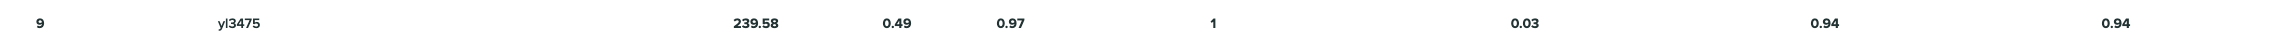

#Appendix
---


## Approximate Projected Point Breakdown

- Q1. Dataset observations (5)
- Q1.1 Implement and discuss the metric(s) (5)
- Q2. Implement your own model (20)
- Q3. Evaluate your own model (10)
- Q4. Implement finetuning (25)
- Q5. Evaluate finetuned model (10)
- Q6. Compare the results (5)
- Q7. Failure analysis (5)
- Q8. Predictions submission (5)
- Code quality (5)
- Page assignment and clarity (5)







## Gradescope Details

Below is a sample `solution.py` code to submit on gradescope. This is also available on Piazza! As it stands, it will not run but this is because the QA model is currently not defined. This is something you will need to write.

```python
import os
import pathlib
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import re

import requests
import torch
import transformers

directory = pathlib.Path(__file__).parent.absolute()

drive_path = "https://drive.google.com/file/d/1NbdW7rPuuCd6ij4bR_2yLL8zGvqfyVIb/view?usp=sharing"

gdrive_id = re.search("https://drive.google.com/file/d/(.*)/view\?usp=sharing", drive_path).group(1)
# print(f"GDrive ID: {gdrive_id}")

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


download_file_from_google_drive(gdrive_id, f"{str(directory / 'netid_parameters.zip')}")
print("Parameters downloaded")

proc = subprocess.Popen([f"unzip -o {str(directory / 'netid_parameters.zip')} -d {str(directory)}"], stdout = subprocess.PIPE, shell=True)

(out, error) = proc.communicate()
pathlib.Path(f"{str(directory / 'netid_parameters.zip')}").unlink()
pathlib.Path(f"{str(directory / 'netid_parameters')}").unlink()


get_device = lambda : "cuda:0" if torch.cuda.is_available() else "cpu"
model = BertQAModel.from_pretrained(str(directory / "netid_parameters" / "model")).to(get_device())
tokenizer = BertTokenizer.from_pretrained(str(directory / "netid_parameters" / "tokenizer"))

model.eval()
print("Model loaded")


def predict(question, context):
    '''predict uses your PCE model and predicts the answer and answerability

    Takes a `question` string and an `context` string (which contains the
    answer), and identifies the words within the `context` that are the
    answer, and if there is an answer

    :param question: The question to answer
    :type question: str
    :param context: The context in which to search for the answer
    :type context: str
    :return: A pair of (answer, hasAns) that represents the model's prediction
        on the answer and whether this question is answerable
    :rtype: Tuple[str, bool]
    '''
    with torch.no_grad():
        # ======== Tokenize ========
        # Apply the tokenizer to the input text, treating them as a text-pair.
        input_ids = tokenizer.encode(question, context, max_length=512, truncation=True,)

        # Report how long the input sequence is.
        # print('Query has {:,} tokens.\n'.format(len(input_ids)))

        # ======== Set Segment IDs ========
        # Search the input_ids for the first instance of the `[SEP]` token.
        sep_index = input_ids.index(tokenizer.sep_token_id)

        # The number of segment A tokens includes the [SEP] token istelf.
        num_seg_a = sep_index + 1

        # The remainder are segment B.
        num_seg_b = len(input_ids) - num_seg_a

        # Construct the list of 0s and 1s.
        segment_ids = [0]*num_seg_a + [1]*num_seg_b

        # There should be a segment_id for every input token.
        assert len(segment_ids) == len(input_ids)

        # ======== Evaluate ========
        # Run our example question through the model.
        start_scores, end_scores = model(torch.tensor([input_ids]).to(get_device()), # The tokens representing our input text.
                                        token_type_ids=torch.tensor([segment_ids]).to(get_device())) # The segment IDs to differentiate question from context

        # ======== Reconstruct Answer ========
        # Find the tokens with the highest `start` and `end` scores.
        answer_start = torch.argmax(start_scores.cpu())
        answer_end = torch.argmax(end_scores.cpu())

        # Get the string versions of the input tokens.
        tokens = tokenizer.convert_ids_to_tokens(input_ids)

        # Start with the first token.
        answer = tokens[answer_start]

        # Select the remaining answer tokens and join them with whitespace.
        for i in range(answer_start + 1, answer_end + 1):
            
            # If it's a subword token, then recombine it with the previous token.
            if tokens[i][0:2] == '##':
                answer += tokens[i][2:]
            
            # Otherwise, add a space then the token.
            else:
                answer += ' ' + tokens[i]

        # print('Answer: "' + answer + '"')

        return answer, True

```
